<h1>Algoritmo Genético - Trabajo IA 2018</h1>
Integrantes

- Sebastian Gaete
- Elard Koch
- Israel Díaz
- Francisco González

**notas**<br>
representación de individuo:
diccionario de python, el cual posee las siguientes claves,valores:

- **doors**: lista de puertas asociadas
- **ticks**: cantidad de ticks promedio del individuo
- **gen**: generación del individuo

una población de  individuos corresponderá a una lista de diccionarios

In [58]:
netlogo = None

In [70]:
import platform
import pyNetLogo
import random
import numpy as np

netlogo_gui=False #ejecutar netlogo con interfaz grafica (True = si, False = no)
current_gen = 0 #contador de la generación actual
max_gen=5 #total de generaciones
n_doors = 5 #numero de puertas a ubicar
pop_size=10 #tamaño poblacion
n_iterations=2 #cantidad de iteraciones por individuo
n_tournament=3 #cantidad de individuos por torneo
p_cross=0.3#probabilidad de recombinacion
p_mut=0.3 #probabilidad de mutacion

plan_file="office.plan"

population = []
good_doors=[] #lista de coordenadas que pueden albergar una puerta 

- Para iniciar netlogo: **launch_netlogo()**
- Para iniciar netlogo: **kill_netlogo()**

In [71]:

def launch_netlogo():
    global netlogo
    print("Trying to start netlogo, please wait...")
    try:
        sistema=platform.system()
        if(sistema=='Windows'):
            netlogo = pyNetLogo.NetLogoLink(gui=netlogo_gui)
        elif(sistema=='Linux'):
            netlogo = pyNetLogo.NetLogoLink(gui=netlogo_gui,netlogo_home='NetLogo 6.0.4/')
        else:
            netlogo = pyNetLogo.NetLogoLink(gui=netlogo_gui)
        print("Done!")
    except Exception as e:
        print("Ocurrio un problema al levantar netlogo!")
        print(e)

def kill_netlogo():
    global netlogo
    if netlogo!=None:
        try:
            netlogo.kill_workspace()
            netlogo = None
        except Exception as e:
            print("An exception has ocurred while attempíng to kill NetLogo!")
            print(e)
    else:
        print("Please start netlogo first before kill it")

<h1>Funciones para algoritmo genético</h1>

In [72]:
#simulate recibe la lista ordenada de coordenadas de puertas, realiza la simulación correspondiente y retorna los ticks que ha demorado
#La distribución de puertas debe estar previamente validada, en caso de que las puertas no sean accesibles, la simulación podría quedar atascada en un while infinito
def simulate(doors):
    str_command = "set door-data {0}".format(str(doors).replace(',','').replace("[","[ ").replace("]"," ]")).replace("(","[").replace(")","]")
    netlogo.command(str_command)
    netlogo.command("show-plan")
    netlogo.command("generate-population")
    while(netlogo.report("count turtles")>0):
        netlogo.command("go")
    return(netlogo.report("ticks"))

def simulate_ind(individual):
    doors = list(map(lambda i:[good_doors[i][0],good_doors[i][1]],individual['doors']))
    return simulate(doors)
    
def get_good_doors(): #Obtener las coordenadas x e y de todas las puertas(posibles) que nos sirven
    x=list(map(lambda i:int(i),netlogo.report("listax")))
    y=list(map(lambda i:int(i),netlogo.report("listay")))
    return list(map(lambda i:(x[i],y[i]),range(len(x))))

def gen_zero(): #crea la generacion 0
    tmp_population=[]
    for i in range(pop_size):
        individual = {
            'doors':[],
            'gen':0,
            'ticks':0
        }
        tmp_population.append(individual)
        for j in range(n_doors):
            random_door_index = random.randint(0,len(good_doors) - 1)
            individual['doors'].append(random_door_index)
    return tmp_population
        

def evaluate_population(pop):
    for individual in pop:
        simulations_ticks=[]
        for i in range(n_iterations):
            ticks = simulate_ind(individual)
            simulations_ticks.append(ticks)
        individual['ticks'] = np.mean(simulations_ticks)
        
# def do_tournament(pop,n_players):
#     result = []
#     tmp_pop = pop.copy()
#     if(n_players > len(pop)):
#         n_players=len(pop)
#     while len(tmp_pop) >= n_players:
#         players_selection = []
#         while(len(players_selection)<n_players):
#             selection = np.random.choice(tmp_pop)
#             if(selection not in players_selection):
#                 players_selection.append(selection)
#         players_doors=list(map(lambda p:p['doors'],players_selection))
#         winner = players_selection[np.argmin([ i['ticks'] for i in players_selection])]
#         tmp_pop=list(filter(lambda p:p['doors'] not in players_doors,tmp_pop))
#         result.append(winner)
#     if(len(tmp_pop)>0):
#         winner = tmp_pop[np.argmin([ i['ticks'] for i in tmp_pop])]
#         result.append(winner)
#         tmp_pop=list(filter(lambda p:p['doors'] not in players_doors,tmp_pop))
#     return result
def do_tournament(pop,n_players):
    result = []
    tmp_pop = pop.copy()
    if(n_players > len(pop)):
        n_players=len(pop)
    for i in range(len(tmp_pop)):
        players_selection = []
        for j in range (n_players):
            selection = np.random.choice(tmp_pop)
            players_selection.append(selection)
        winner = players_selection[np.argmin([ i['ticks'] for i in players_selection])]
        result.append(winner)    
    return result

def do_crossover(pop,gen_number=0):
    new_pop=[]
    punto_corte = random.randint(1,n_doors - 1)
    for i in range(len(pop)//2):
        parent1=pop[i]['doors']
        parent2=pop[len(pop)//2 + i]['doors']
        new_individual = {
            'doors':parent1[:punto_corte] + parent2[punto_corte:],
            'gen':gen_number,
            'ticks':0
        }
        new_pop.append(new_individual)
    return new_pop

def do_mutate(pop,prob=p_mut):
    new_pop = pop.copy()
    for individual in new_pop:
        if np.random.random() <= prob:
            random_index = random.randint(0,n_doors - 1)
            new_door = np.random.randint(len(good_doors))
            while(new_door == individual['doors'][random_index]):
                new_door = np.random.randint( len(good_doors))
            individual['doors'][random_index] = new_door
            individual['ticks']=0
    return new_pop

def get_best_from_pop(pop):
    best_index = np.argmin(list(map(lambda p:p['ticks'],pop)))
    best = pop2[best_index]
    return best

In [73]:
# kill_netlogo()
launch_netlogo()

Trying to start netlogo, please wait...
Done!


In [74]:
netlogo.load_model(r'escape4_v6.nlogo')

<h1>Bucle evolutivo</h1>

In [75]:
import time


netlogo.command('set plan-data "{0}"'.format(plan_file))
netlogo.command("load-plan-file")

good_doors = get_good_doors() #guardar las puertas posibles en good_doors

start_time = time.time()
print("Generating population...")
pop2 = gen_zero()
print("Done!")
#print("|{0:_^5}|".format("Gen"))

best_of = []

while current_gen <= max_gen:
#     iter_time = time.time()
    print("{0:#^10}".format("Gen " + str(current_gen)))
    print("Population size: {0}".format(len(pop2)))
    print("Evaluating...",end="")
    
    evaluate_population(list(filter(lambda p:p['ticks'] ==0,pop2)))
        
    print("Done!")
    if(current_gen < max_gen):
        print("Tournament...",end="")
        winners = do_tournament(pop2,n_tournament)
        print("Done!")
        print("Crossing...",end="")
        cross = do_crossover(winners, current_gen + 1)
        print("Done!")
        print("Mutation phase...",end="")
        result = do_mutate(cross)
        print("Done!")

        """
        print("Tournament (again)...",end="")
        pop2 = do_tournament(result + pop2,3)
        print("Done!")
        """

#         pop2=result + pop2
        pop2=result
        
    best_of_this_gen = get_best_from_pop(pop2)#encontrar el mejor (para realizar el grafico)
    best_of.append( (current_gen,best_of_this_gen,best_of_this_gen))#guardarlo en una lista junto con la genereacion (para el grafico)                                     
    
    print("Gen analysis finished")
#     elapsed_time = time.time() - iter_time
#     print("Elapsed time: {0}".format(elapsed_time))
    current_gen = current_gen + 1
# print(pop2)
elapsed_time = time.time() - start_time
print("Total elapsed time: {0}".format(elapsed_time))

kill_netlogo()

Generating population...
Done!
##Gen 0###
Population size: 10
Evaluating...Done!
Tournament...Done!
Crossing...Done!
Mutation phase...Done!
Gen analysis finished
##Gen 1###
Population size: 25
Evaluating...

KeyboardInterrupt: 

Best door combination:
[(81, 61), (123, 20), (50, 61), (48, 5), (123, 51)]
ticks:75.0


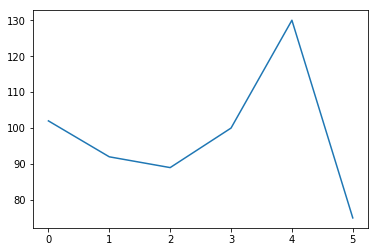

In [48]:
import matplotlib.pyplot as plt

x_points=list(map(lambda x:x[0],best_of))
y_points=list(map(lambda x:x[1]['ticks'],best_of))

best_of_all_time_index = np.argmin(y_points)
best_of_all_time = best_of[best_of_all_time_index][1]
best_doors = list(map(lambda i:good_doors[i] ,best_of_all_time['doors']))

print("Best door combination:\n{0}\nticks:{1}".format(best_doors,best_of_all_time['ticks']))

plt.plot(x_points,y_points)
plt.show()

In [67]:
pop=gen_zero()
pop2

[{'doors': [168, 58, 260, 193, 276], 'gen': 5, 'ticks': 85.4},
 {'doors': [37, 230, 85, 193, 276], 'gen': 5, 'ticks': 88.0},
 {'doors': [277, 112, 82, 39, 186], 'gen': 5, 'ticks': 96.4},
 {'doors': [253, 128, 210, 172, 61], 'gen': 5, 'ticks': 91.6},
 {'doors': [276, 67, 95, 45, 55], 'gen': 5, 'ticks': 129.4},
 {'doors': [248, 58, 130, 39, 186], 'gen': 5, 'ticks': 104.2},
 {'doors': [168, 58, 260, 45, 260], 'gen': 0, 'ticks': 87.8},
 {'doors': [37, 230, 85, 202, 136], 'gen': 0, 'ticks': 83.4},
 {'doors': [277, 112, 82, 200, 61], 'gen': 4, 'ticks': 84.0},
 {'doors': [253, 128, 210, 78, 156], 'gen': 0, 'ticks': 92.0},
 {'doors': [276, 67, 95, 238, 251], 'gen': 0, 'ticks': 103.2},
 {'doors': [248, 50, 130, 200, 23], 'gen': 3, 'ticks': 90.2},
 {'doors': [253, 128, 210, 193, 276], 'gen': 3, 'ticks': 94.0},
 {'doors': [277, 67, 82, 193, 276], 'gen': 0, 'ticks': 91.0},
 {'doors': [260, 204, 17, 39, 186], 'gen': 1, 'ticks': 102.2},
 {'doors': [125, 277, 5, 172, 61], 'gen': 0, 'ticks': 100.6},
 